# BVP: Boundary value problems
[Boundary value problems](https://en.wikipedia.org/wiki/Boundary_value_problem) (BVP) are very common in both theoretical (Sturm-Liuvoille problems) and engineering applications . In this case, boundary, not initial, conditions are specified. For example, you specify the initial and final positions of a particles, instead of the initial position and velocity. A typical application is the [infinite well](https://en.wikipedia.org/wiki/Particle_in_a_box?useskin=vector), where the particle must have :

<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Infinite_potential_well-en.svg/330px-Infinite_potential_well-en.svg.png" width=30%>
<figcaption>https://en.wikipedia.org/wiki/Particle_in_a_box?useskin=vector </figcaption>
</figure>

BVP are more difficult to solve, and also represent our first step towards partial differential equations. Here will learn how to use IVP techniques to solve BVP by using the so-called [shooting method](https://en.wikipedia.org/wiki/Shooting_method). We will also check an alternative formulation, in terms of [finite differences](https://en.wikipedia.org/wiki/Finite_difference_method), where the BVP will be written as a matrix problem that will be solved using the previously seen techniques. We will also compare our solutions with the ones obtained from using `scipy` and the `solve_ivp` method, [solve_bvp](https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.integrate.solve_bvp.html).

## Shooting method
The [shooting method](https://en.wikipedia.org/wiki/Shooting_method) uses IVP solutions to estimate the best initial condition to solve the BVP. Imagine that you want to estimate the initial velocity for the cannon ball in order to make sure that it hits a given target at position $b$. 

<figure>
<img src="https://pythonnumericalmethods.berkeley.edu/_images/23.02.01-shooting.png" width=60%>
<figcaption>Reproducido de: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter23.02-The-Shooting-Method.html </figcaption>
</figure>

## Linear shooting method: interpolation

The *linear* shooting method solves the problem for two different initial conditions, and from them computes the exact initial conditions needed (**on the derivative**).  Then it solves again the BVP as a simple IVP given the extra and correct initial condition found. Let's assume we have a linear second order equation. If you put the initial values $(y_{0}, v_{0a})$, you get the final value $y_{fa}$ (first ICP solution). If you put the initial values $(y_{0}, v_{0b})$, you get the final value $y_{fb}$ (second IVP solution). 

For instance, let's check the following example:


In [33]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Define the second-order differential equation (e.g., damped harmonic oscillator)
def ode(t, y, k, b):
    """
    Defines the system of first-order differential equations 
    representing the second-order ODE.

    Args:
      t: Time.
      y: Array containing [y, y'].
      k: Spring constant.
      b: Damping coefficient.

    Returns:
      Array containing [y', y''].
    """
    y1, y2 = y
    return [y2, -k * y1 - b * y2]

# Function to solve and plot the ODE
def solve_and_plot(k, b, y0, v0):
    """
    Solves the ODE using solve_ivp and plots the solution.

    Args:
      k: Spring constant.
      b: Damping coefficient.
      y0: Initial displacement.
      v0: Initial velocity.
    """
    t_span = (0, 10)  # Time interval for integration
    y0_vec = [y0, v0]  # Initial conditions as a vector

    # Solve the ODE
    sol = solve_ivp(ode, t_span, y0_vec, args=(k, b), dense_output=True)

    # Generate time points for plotting
    t_plot = np.linspace(t_span[0], t_span[1], 100)

    # Interpolate the solution at the plotting points
    y_plot = sol.sol(t_plot)[0]

    # Plot the solution
    plt.figure()
    plt.plot(t_plot, y_plot)
    plt.xlabel("Time")
    plt.ylabel("Displacement")
    plt.title(f"k={k:.2f}, b={b:.2f}, y0={y0:.2f}, v0={v0:.2f}, yf={y_plot[-1]:.2f}")
    plt.grid(True)
    plt.show()

# Create interactive widgets
k_slider = FloatSlider(min=0, max=10, step=0.1, value=1, description='k')
b_slider = FloatSlider(min=0, max=5, step=0.1, value=0.5, description='b')
y0_slider = FloatSlider(min=-5, max=5, step=0.1, value=1, description='y0')
v0_slider = FloatSlider(min=-10, max=10, step=0.5, value=0, description='v0')

# Create the interactive plot
interact(solve_and_plot, k=k_slider, b=b_slider, y0=y0_slider, v0=v0_slider)


interactive(children=(FloatSlider(value=1.0, description='k', max=10.0), FloatSlider(value=0.5, description='b…

<function __main__.solve_and_plot(k, b, y0, v0)>

In [13]:
# TODO for you: Create a plot of the final position as a function of y0, with fixed parameters


In general, if the problem is linear, one has that a given initial condition in the first derivative gives a unique final value in position, 

<img src="./fig/BVP-solutions.png" width=60% alt="From Cheney et al: Numerical Mathematics and Computing">

and if this functions is linear (given that the equation is linear) then we can interpolate as shown

<img src="./fig/BVP-linear-interpolation.png" width=60% alt="From Cheney et al: Numerical Mathematics and Computing">


By taking into account the linear nature of the problem, we can compute the straight-line equation in the $v_0 - y_f$ space to get the right initial condition as 
\begin{equation}
v_0 = v_{0a} + \frac{y_f - y_{fa}}{y_{fb} - y_{fa}}(v_{0b} - v_{0a}).
\end{equation}
Then, by using that initial condition, we compute the actual solution (third IVP solution).

**EXAMPLE**

As an example, let's solve the following problem (Chapra 24.11): Compound $A$ diffuses through a 4-cm-long tube and reacts as it diffuses. The process can be  modeled as

\begin{equation}
D\frac{d^2A}{dx^2} - kA = 0.  
\end{equation}
At $x=0$ there is a large source of $A$ with fixed concentration of $0.1$ M. At the other end there is a material that quickly absorbs $A$, so the concentration is 0 M. If $D = 1.5\times 10^{-6}$ cm$^2$/s and $k = 5\times 10^{-6}$ s$_1$, what is the concentration along the tube?

Write a function that returns the correct initial derivative value and plots the concentration along the tube. The pseudo algorithm would be
```conf
- Solve the ivp with an arbitrary (but reasonable) initial condition on velocity. Store the final "position" value.
- Solve the ivp with another arbitrary (but reasonable) initial condition on velocity. Store the final "position" value.
- Applyt hte interpolation formula to compute the appropriate initial condition. 
- Plot the final solution
```

np.float64(-0.1825741514595312)

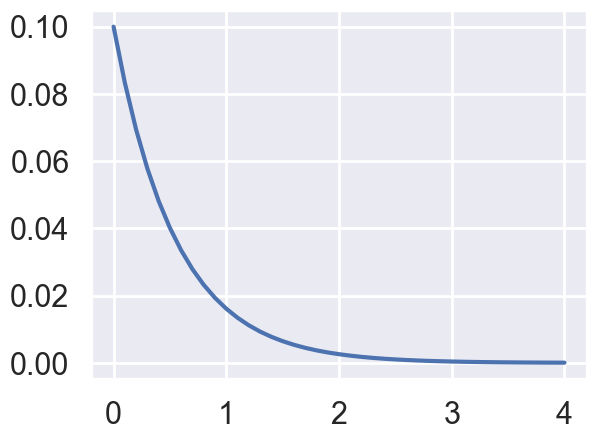

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_context("poster")

def deriv(t, y, params):
    return [y[1], params[1]*y[0]/params[0]]

def mysolve_bvp(y0, yf, v0a, v0b, t0, tf, dt, params):
    ### BEGIN SOLUTION
    aux = lambda x: solve_ivp(deriv, [t0, tf], [y0, x], t_eval=np.arange(t0, tf+dt, dt), 
                              args=(params,))
    # first solution
    sola = aux(v0a)
    yfa = sola.y[0][-1]
    # second solution
    solb = aux(v0b)
    yfb = solb.y[0][-1]
    # linear interpolation
    v0 = v0a + (yf - yfa)*(v0b - v0a)/(yfb - yfa)
    # third-final solution
    sol = aux(v0)
    # plot
    fig, ax = plt.subplots()
    ax.plot(sol.t, sol.y[0])
    return v0
    ### END SOLUTION

PARAMS = (1.5e-6, 5e-6)
mysolve_bvp(0.1, 0.0, -0.23, -0.14, 0.0, 4.0, 0.1, PARAMS)

## Linear shooting method: root finding 
The previous problem can be written as a root finding procedure. And this allows to generalize the procedure to non-linear problems. If we see the IVP solution as a function of the initial velocity condition, $y_f = g(v_0)$ (plus other parameters), then we can see this problem as a root finding one, looking for the right $v_0$ that gives $h(v_0) = 0 = g(v_0) - y_f$. As you can see later, this will allow us to extend the shooting method to non-linear problems. Python allows us to compute roots using the [`scipy.optimize.root`](https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.optimize.root.html) method.

Found initial velocity: -0.18257435225266527


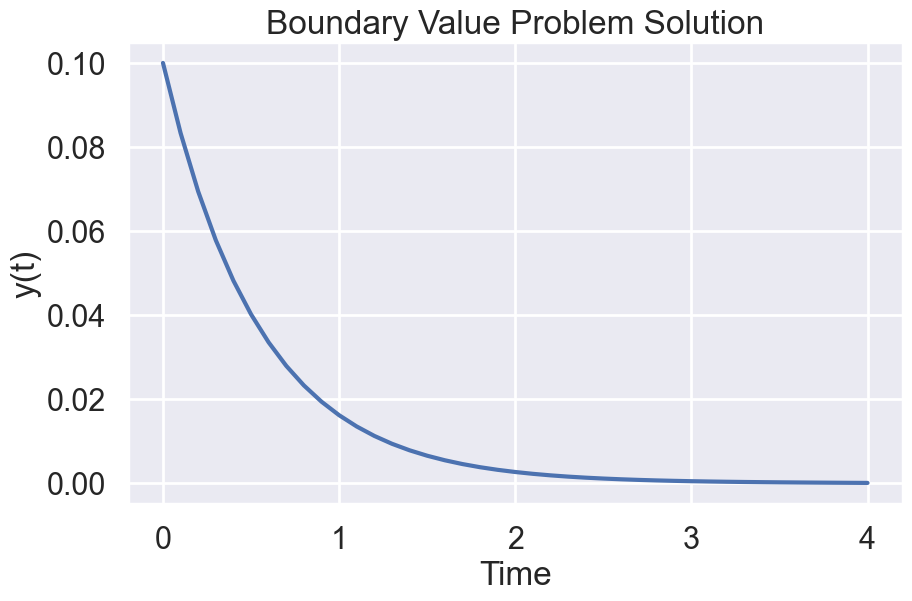

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.integrate import solve_ivp

# Set up seaborn styling
sns.set()
sns.set_context("poster")

def deriv(t, y, params):
    """Derivative function for the ODE system"""
    return [y[1], params[1]*y[0]/params[0]]

def h(v0, y0, yf, t0, tf, dt, params):
    """Function to be zeroed - returns the difference between computed final value and desired final value"""
    # Convert v0 to float in case it comes as an array
    #print(v0)
    v0 = v0[0]
    ### BEGIN SOLUTION
    # Solve IVP
    sol = solve_ivp(deriv, [t0, tf], [y0, v0], 
                    t_eval=np.arange(t0, tf+dt, dt), 
                    args=(params,))
    # Return the difference between computed final value and desired final value
    return sol.y[0][-1] - yf
    ### END SOLUTION

def solve_bvp_root(y0, yf, v0_guess, t0, tf, dt, params):
    """Solve the boundary value problem using root finding"""
    # Find the initial velocity that satisfies the boundary condition
    result = root(h, v0_guess, args=(y0, yf, t0, tf, dt, params))
    v0 = result.x[0]
    print(f"Found initial velocity: {v0}")
    
    # Solve the IVP with the found initial velocity
    sol = solve_ivp(deriv, [t0, tf], [y0, v0], 
                    t_eval=np.arange(t0, tf+dt, dt),
                    args=(params,))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sol.t, sol.y[0], 'b-', label='Solution')
    ax.set_xlabel('Time')
    ax.set_ylabel('y(t)')
    ax.set_title('Boundary Value Problem Solution')
    ax.grid(True)
    plt.show()
    
    return v0

# Example parameters and solution
PARAMS = (1.5e-6, 5e-6)
v0_solution = solve_bvp_root(0.1, 0.0, -0.23, 0.0, 4.0, 0.1, PARAMS)

## Non linear shooting method
As we said, formulating the problem as a root finding one allows us to extend the method to non-linear systems (there are even better generalization like the  https://en.wikipedia.org/wiki/Direct_multiple_shooting_method). Let's now solve the same problem but adding some  drag coefficient, $f_v = -b v$

Found initial velocity: -0.18257435225266516


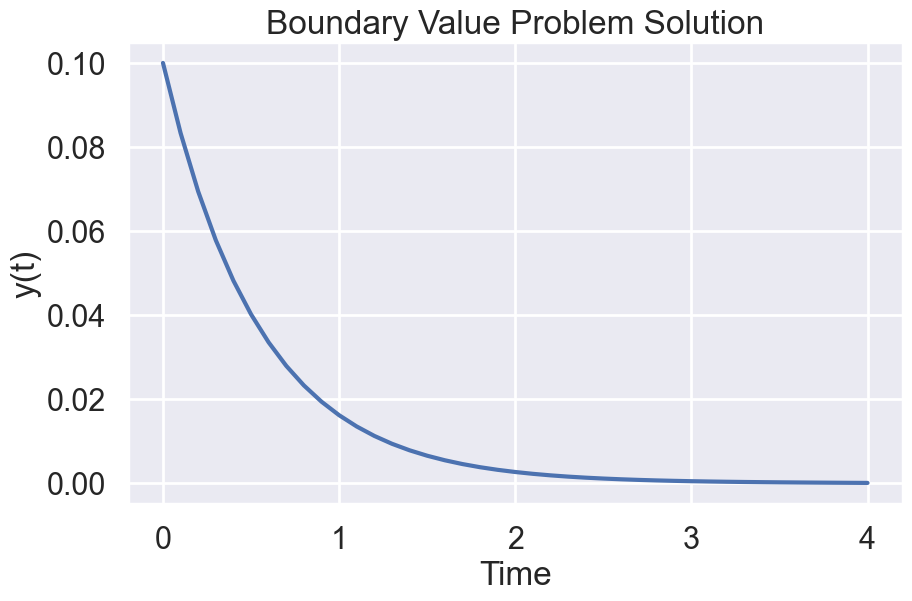

Found initial velocity: -0.5498253268703548


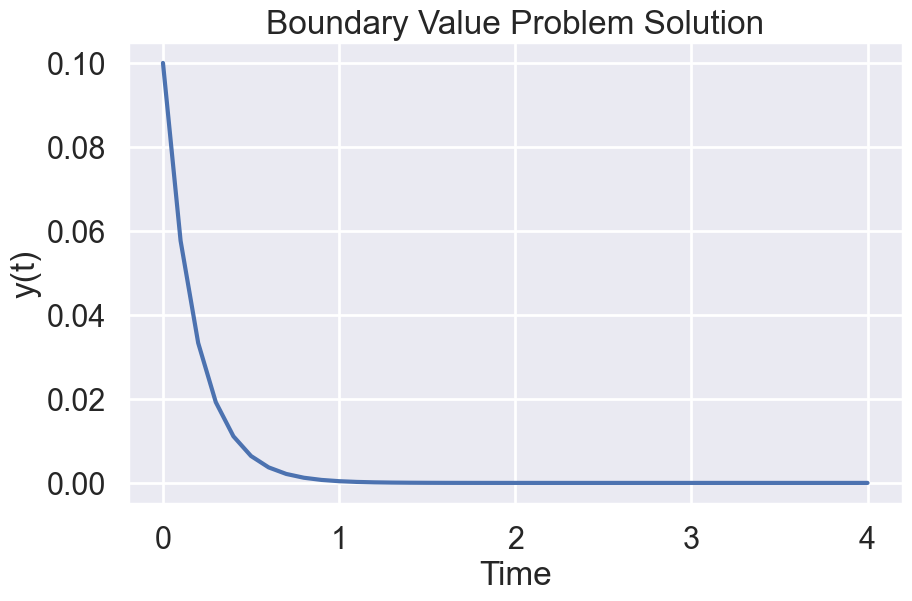

np.float64(-0.5498253268703548)

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.integrate import solve_ivp

# Set up seaborn styling
sns.set()
sns.set_context("poster")

def deriv(t, y, params):
    """Derivative function for the ODE system"""
    return [y[1], params[1]*y[0]/params[0] - params[2]*y[1]]

def h(v0, y0, yf, t0, tf, dt, params):
    """Function to be zeroed - returns the difference between computed final value and desired final value"""
    # Convert v0 to float in case it comes as an array
    #print(v0)
    v0 = v0[0]
    ### BEGIN SOLUTION
    # Solve IVP
    sol = solve_ivp(deriv, [t0, tf], [y0, v0], 
                    t_eval=np.arange(t0, tf+dt, dt), 
                    args=(params,))
    # Return the difference between computed final value and desired final value
    return sol.y[0][-1] - yf
    ### END SOLUTION

def solve_bvp_root(y0, yf, v0_guess, t0, tf, dt, params):
    """Solve the boundary value problem using root finding"""
    # Find the initial velocity that satisfies the boundary condition
    result = root(h, v0_guess, args=(y0, yf, t0, tf, dt, params))
    v0 = result.x[0]
    print(f"Found initial velocity: {v0}")
    
    # Solve the IVP with the found initial velocity
    sol = solve_ivp(deriv, [t0, tf], [y0, v0], 
                    t_eval=np.arange(t0, tf+dt, dt),
                    args=(params,))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sol.t, sol.y[0], 'b-', label='Solution')
    ax.set_xlabel('Time')
    ax.set_ylabel('y(t)')
    ax.set_title('Boundary Value Problem Solution')
    ax.grid(True)
    plt.show()
    
    return v0

# Example parameters and solution
PARAMS = (1.5e-6, 5e-6, 0.0)
solve_bvp_root(0.1, 0.0, -0.33, 0.0, 4.0, 0.1, PARAMS)
PARAMS = (1.5e-6, 5e-6, 4.8920)
solve_bvp_root(0.1, 0.0, +0.33, 0.0, 4.0, 0.1, PARAMS)

## Using `scipy`: `solve_bvp`
The `scipy` module offers an useful function, [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.integrate.solve_bvp.html) , to solve the problems we have been exploring. Check the manual and adapt the method Be careful: parameters are now treated as something that can vary, like the initial velocity or the energy in a quantum system, so our previous parameter use should be updated. 

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.59e-07       2.22e-16          100             0       
Solved in 1 iterations, number of nodes 100. 
Maximum relative residual: 6.59e-07 
Maximum boundary residual: 2.22e-16
None
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.07e-05       2.78e-17          100             0       
Solved in 1 iterations, number of nodes 100. 
Maximum relative residual: 5.07e-05 
Maximum boundary residual: 2.78e-17
None


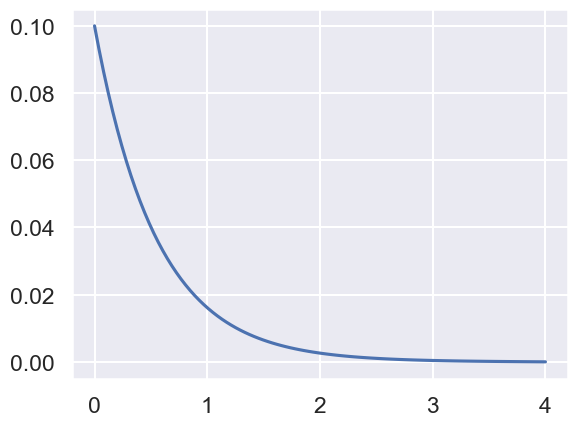

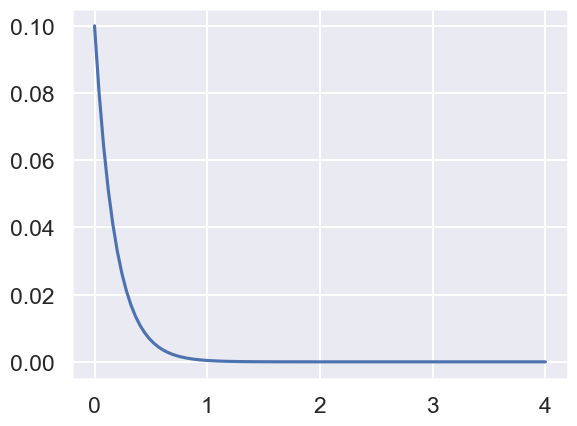

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
sns.set()
sns.set_context("talk")

def deriv(t, y, params):
    ### BEGIN SOLUTION
    return [y[1], params[1]*y[0]/params[0] - params[2]*y[1]]
    ### END SOLUTION
    

def bc(ya, yb, params):
    ### BEGIN SOLUTION
    return [ya[0]-0.1, yb[0]] # change the initial velocity
    ### END SOLUTION
    

def mysolve_bvp(x, y0, params):
    ### BEGIN SOLUTION
    # model it as a 2-arg funtion, params are physical and should not change
    f_wrapper = lambda x, y0: deriv(x, y0, params)
    bc_wrapper = lambda ya, yb: bc(ya, yb, params)
    sol = solve_bvp(f_wrapper, bc_wrapper, x, y0, verbose=2) # print more info
    ### END SOLUTION
    
    return sol

for PARAMS in [np.array([1.5e-6, 5e-6, 0.0]), np.array([1.5e-6, 5e-6, 4.8920])]:
    x = np.linspace(0, 4.0, 100)
    y0 = np.ones((2, x.size))
    fig, ax = plt.subplots()
    ax.plot(sol.x, sol.y[0])
    print(sol.p)

In [3]:
%%writefile fixed_param.py
# This is an example on how to handle fixed and changing params
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
sns.set()
sns.set_context("talk")

def deriv(t, y, params, fixed_params):
    ### BEGIN SOLUTION
    return [y[1], fixed_params[1]*y[0]/fixed_params[0] - fixed_params[2]*y[1]]
    ### END SOLUTION
    

def bc(ya, yb, params, fixed_params):
    ### BEGIN SOLUTION
    return [ya[0]-0.1, yb[0], ya[1] - params[0]] # change the initial velocity
    ### END SOLUTION
    

def mysolve_bvp(x, y0, params, fixed_params):
    ### BEGIN SOLUTION
    sol = solve_bvp(lambda x, y0, params: deriv(x, y0, params, fixed_params), # model it as a 3-arg funtion, does not change fixed_params
                    lambda ya, yb, params: bc(ya, yb, params, fixed_params),  # model it as a 3-arg funtion, does not change fixed_params
                    x, y0, p=params, 
                    verbose=2) # print more info
    ### END SOLUTION
    
    return sol

for PARAMS in [np.array([1.5e-6, 5e-6, 0.0]), np.array([1.5e-6, 5e-6, 4.8920])]:
    x = np.linspace(0, 4.0, 100)
    y0 = np.ones((2, x.size))
    sol = mysolve_bvp(x, y0, np.array([1.0]), PARAMS)
    fig, ax = plt.subplots()
    ax.plot(sol.x, sol.y[0])
    print(sol.p)


Writing fixed_param.py


## Exercises

### Ecuación de Schroedinger (workshop)
Una partícula se encuentra confinada en un potencial infinito descrito por 

\begin{equation}
  V(x) = 
  \begin{cases}
  0, 0 \le x \le L,\\
  \infty, \textrm{elsewhere}
  \end{cases}
\end{equation}

La ecuación de onda $\phi$ de la partícula (independiente del tiempo) es
\begin{equation}
  \frac{-\hbar^2}{2m} \frac{d^2\phi(x)}{dx^2} + V(x) \phi(x) = E\phi(x).
\end{equation}
Debido al potencial, la función de onda debe cumplir que $\phi(0) = \phi(L) = 0$. 
- Normalice la ecuación de manera que quede expresada en términos de una energía adimensional, posición adimensional, etc (medir la posición en unidades de $L$, etc)
- Resuelva el sistema usando BVP. El valor de $E$ determina los niveles de energía. Busque la solución teórica y piense cómo dar un valor inicial para obteneer cada uno de los niveles de energía.



$x$ is measured in units of $L$. Energy, therefore, in units of $\hbar^2/2mL^2$. Therefore, the equation turns into
\begin{equation}
-\frac{d^2\phi(\hat x)}{d\hat x^2} + \hat V(\hat x) = \hat E \phi(\hat x),
\end{equation}
where $\hat E = n^2\pi^2$.

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_context("talk")
import numpy as np
from scipy.integrate import solve_bvp, trapezoid

def deriv(t, y, params):
    V = 0
    return np.vstack((y[1], -(params[0]-V)*y[0]))

def bc(ya, yb, params):
    return [ya[0] - 0.0, yb[0] - 0.0, ya[1] - 1.0]

def solve_bvpE(x, y0, params):
    ### BEGIN SOLUTION
    sol = solve_bvp(deriv, bc, x, y0, p=params, verbose=2)
    norma = trapezoid(y = np.power(sol.y[0], 2), x = sol.x)
    sol.y[0] /= np.sqrt(norma)
    norma = trapezoid(y = np.power(sol.y[0], 2), x = sol.x)
    print(f"{norma=}")
    return sol
    ### END SOLUTION



   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.60e-06       0.00e+00          100             0       
Solved in 1 iterations, number of nodes 100. 
Maximum relative residual: 5.60e-06 
Maximum boundary residual: 0.00e+00
norma=0.9999999999999999
[9.86954401]


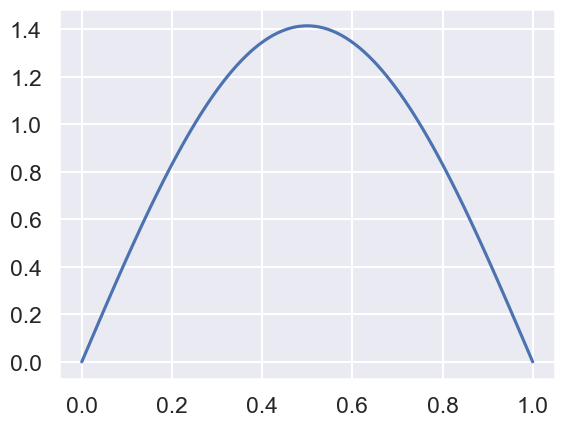

In [234]:
PARAMS = np.array([1.7])
x = np.linspace(0, 1, 100)
y0 = np.ones((2, x.size))
sol = solve_bvpE(x, y0, PARAMS)
fig, ax = plt.subplots()
ax.plot(sol.x, sol.y[0])
print(sol.p)
#print(sol.y[0])

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.65e-05       0.00e+00          100             0       
Solved in 1 iterations, number of nodes 100. 
Maximum relative residual: 1.65e-05 
Maximum boundary residual: 0.00e+00
norma=0.9999999999999999
[39.47842637]


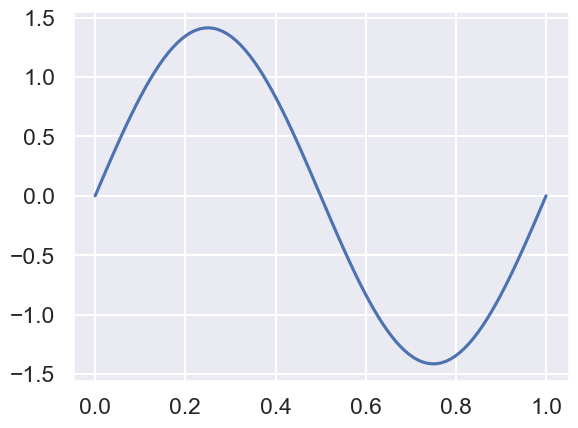

In [240]:
#PARAMS = np.array([39.47])
PARAMS = np.array([39.4])
x = np.linspace(0, 1, 100)
y0 = np.ones((2, x.size))
y0[0, int(-3*x.size/4)] = -1
sol = solve_bvpE(x, y0, PARAMS)
fig, ax = plt.subplots()
ax.plot(sol.x, sol.y[0])
print(sol.p)
#print(sol.y[0])

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.55e-01       0.00e+00          100            113      
       2          1.91e-06       0.00e+00          213             0       
Solved in 2 iterations, number of nodes 213. 
Maximum relative residual: 1.91e-06 
Maximum boundary residual: 0.00e+00
norma=0.9999999999999999
[88.82643866]


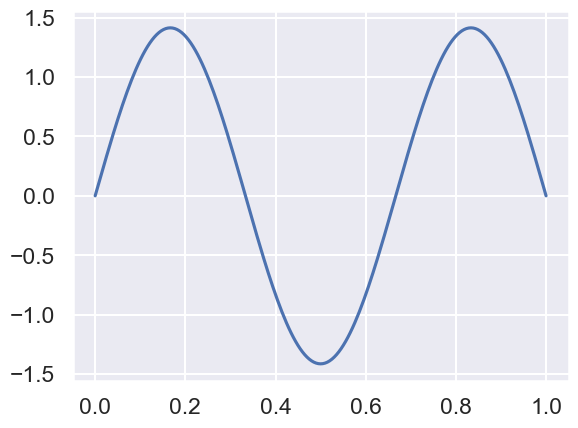

In [228]:
PARAMS = np.array([80.7])
sol = solve_bvpE(0.0, 1.0, 100, 0.0, 0.0, PARAMS)
fig, ax = plt.subplots()
ax.plot(sol.x, sol.y[0])
print(sol.p)

## Matrix formulation for linear boundary value problems
When the BVP is linear, you can solve it either using the interpolation already shown, or by formulating the problem as a matrix system. The later is based on a [finite difference](https://en.wikipedia.org/wiki/Finite_difference_method) discretization for the derivatives. Let's start with the following problem, representing the temperature $T$ across a linear bar (Chapra, 27.1)

\begin{equation}
  \frac{d^2T}{dx^2} + h'(T_a - T) = 0,  
\end{equation}

where $h'$ is the transfer coefficient (m$^{-2}$), and $T_a$ is the sourronding air temperature. The boundary conditions are $T(0) = T_1 = 40$, $T(L=10) = T_2 = 200$, and $T_a = 20$. Also, $h' = 0.01$. 

First, please solve the problem both theoretically and then using `solve_bvp` or yout own method.

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.87e-08       5.68e-14          100             0       
Solved in 1 iterations, number of nodes 100. 
Maximum relative residual: 1.87e-08 
Maximum boundary residual: 5.68e-14
12.690455824985827
(0.01, 20.0)


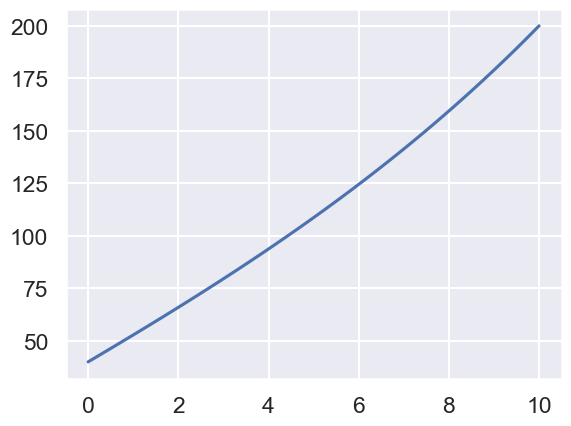

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
sns.set()
sns.set_context("talk")

def deriv(t, y, params):
    ### BEGIN SOLUTION
    hprime, Ta = params[0], params[1]
    return [y[1], hprime*(y[0] - Ta)]
    ### END SOLUTION

def bc(ya, yb, params):
    ### BEGIN SOLUTION
    return [ya[0]-40, yb[0]-200]
    ### END SOLUTION

def solve_bvp_plot(x0, xf, params):
    ### BEGIN SOLUTION
    N=100 # Number of points in the horizontal direction
    NDIM = 2 # Dimensions in the state vector
    deriv_wrapper = lambda t, y: deriv(t, y, params)
    bc_wrapper = lambda ya, yb: bc(ya, yb, params)
    sol = solve_bvp(deriv_wrapper, bc_wrapper, np.linspace(x0, xf, N), np.zeros((NDIM, N)), verbose=2)
    # plot
    fig, ax = plt.subplots()
    ax.plot(sol.x, sol.y[0])
    print(sol.y[1][0])
    ### END SOLUTION

PARAMS = (0.01, 20.0)
solve_bvp_plot(0.0, 10.0, PARAMS)
print(PARAMS)

12.690853836888632

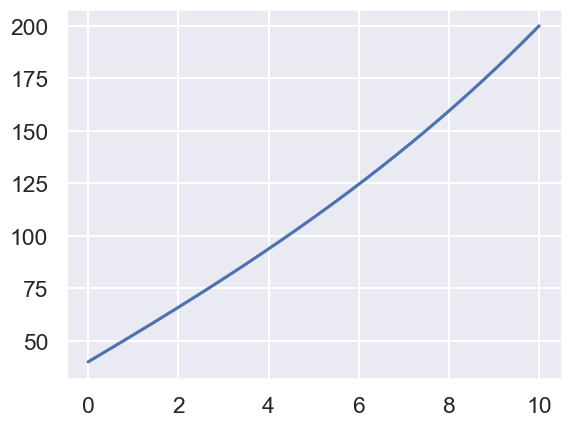

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.integrate import solve_ivp
sns.set()
sns.set_context("talk")

def deriv(t, y, params):
    ### BEGIN SOLUTION
    return [y[1], params[0]*(y[0] - params[1])]
    ### END SOLUTION

def h(v0, y0, yf, t0, tf, dt, params):
    ### BEGIN SOLUTION
    return solve_ivp(deriv, [t0, tf], [y0, v0], t_eval=np.arange(t0, tf+dt, dt), 
                     args=(params,)).y[0][-1] - yf
    ### END SOLUTION

def solve_bvp_root(y0, yf, v0, t0, tf, dt, params):
    ### BEGIN SOLUTION
    # Compute the root : v0 such us h(v0) = 0
    v0 = root(h, v0, args=(y0, yf, t0, tf, dt, params)).x[0]
    # Use the solution and solve the ivp
    sol = solve_ivp(deriv, [t0, tf], [y0, v0], t_eval=np.arange(t0, tf+dt, dt),
                    args=(params,))
    # plot
    fig, ax = plt.subplots()
    ax.plot(sol.t, sol.y[0])
    return v0
    ### END SOLUTION

PARAMS = (0.01, 20)
solve_bvp_root(40.0, 200.0, 10.9, 0.0, 10.0, 0.01, PARAMS)

Now let's proceed with a different way: by discretizing the derivatives and setting the equation on the points. We have,

\begin{equation}
\frac{d^2T}{dx^2} \simeq \frac{T_{i+1} - 2T_i + T_{i-1}}{\Delta x^2},  
\end{equation}
where $\Delta x$ is the partition size, so the original equation takes the form
\begin{equation}
\frac{T_{i+1} - 2T_i + T_{i-1}}{\Delta x^2} - h'(T_i - T_a) = 0.  
\end{equation}
Finally, after collecting terms, we have
\begin{equation}
-T_{i-1} + (2+h'\Delta x^2)T_i - T_{i+1} = h'\Delta x^2T_a \to -T_{i-1} + \alpha T_i - T_{i+1} = \beta.
\end{equation}
This is a tri-diagonal system for the internal points.

> **Exercise:** Write the matrix system assuming three internal points plus the boundary points. Hint: Start with $i=1$, you will get $-T_0 + \alpha T_1 - T_2 = \beta$. Then for $i=2$ you get $-T_1 + \alpha T_2 - T_3 = \beta$ and so on. Then you get your matrix system. Your unknowns are the internal points.

Now, given the matrix system, solve it using the already seen matrix methods. Compare with the exact solution and the ones obtained from using the shooting method or `solve_bvp`.

In [ ]:
import numpy as np
import scipy as sp

def solve_bvp_finite_diffs(N, ALPHA, BETA, T1, T2):
    """
    N : number of internal points
    """
    M = np.zeros((N, N))
    b = BETA*np.ones(N) 
    # Set diagonal elements
    ### BEGIN SOLUTION
    M += np.diag(ALPHA*np.ones(N), 0)
    M += np.diag(-1*np.ones(N-1), -1) 
    M += np.diag(-1*np.ones(N-1), +1)
    # Set vector first and last element
    b[0]  += T1
    b[-1] += T2
    ### END SOLUTION
    # Solve the system Mx = b
    x = np.linalg.solve(M, b)
    return np.concatenate(([T1], x, [T2]))

HPRIME = 0.01
L = 10
N = 300
DX = L/(N+2-1) # +2 by adding the boundaries -1 by number of intervals
TA = 20
T1 = 40
T2 = 200
ALPHA = 2 + HPRIME*DX*DX
BETA = HPRIME*DX*DX*TA

T = solve_bvp_finite_diffs(N, ALPHA, BETA, T1, T2)

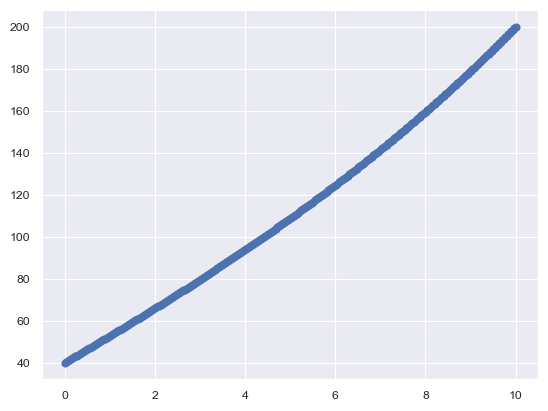

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('paper')
x = DX*np.arange(N+2)
plt.plot(x, T, '-o')


## Additional Exercises

### Generic BVP 
Solve the following equation using the shooting method and the matrix method,
\begin{equation}
7\frac{d^2y}{dx^2} -  2\frac{dy}{dx} - y +x = 0,
\end{equation}
with $y(0) = 5, y(20) = 8$




### BVP with Newman condition
Here we will add a boundary condition on the derivative, on the left, which means that the left node is also an unknown. In that case you can use $dT/dx \simeq = (T_{1} - T_{-1})/2\Delta x$ so $T_{-1} = T_1 -2 \Delta x dT/\Delta x$ and then you get the value for the imaginary node $T_{-1}$ which is now needed. Solve following system:
\begin{equation}
\frac{d^2T}{dr^2} + \frac{1}{r}\frac{dT}{dr} + S = 0,
\end{equation}
over $0 \le r\le 1$, with $T(r=1) = 1$ and $\frac{dT}{dr} = 0$ in $r=0$, for S = 1, 10, and 20 K/m$^2$. This is a model of the temperature distribution on  a circular rod with internal heat source $S$. 

### Deflection of a sailboat mast (Chapra 28.22)
The following equation can be used to model the deflection of a sailboat mast subject to wind force,
\begin{equation}
\frac{d^2y}{dz^2} = \frac{f}{2EI}(L-z)^2,
\end{equation}
where $f$ is the wind force, $E$ is the modulus of elasticity, $L$ the mast length, and $I$ the inertia moment. Compute the deflection as a function of $z$ if $y = 0$ and $dy/dz = 0$ at $z = 0$. Use $f = 60, L = 30, E = 1.25\times 10^8, I = 0.05$

### Deflection of a sailboat mast (Chapra 28.23)
Same previous problem but now the force varies with height as 
\begin{equation}
f(z) = \frac{200z}{5+z}e^{-2z/30}.
\end{equation}